# Analysis on Identifying Cats with AWS Rekognition API

The following project code is hosted at the github link https://github.com/1154219801/AWS-ML-Eval

## Background: 

Many cat owners probably have the question of what they should do when their cat hides somewhere in the house. Cats love hiding in small spaces, such as closets, under the bed, and in storage boxes, which make them feel secure and comfortable. Especially when your cat feels nervous or dangerous, it will disappear immediately from your sight. 

In this project, we decide to evaluate whether Amazon Rekognition has the ability to detect cats and help cat lovers find their missing cats in the house. Amazon Rekognition as a cloud based software is able to identify objects, people, text, scenes, and activities in images and videos. Amazon Rekognition has two API sets: Amazon Rekognition Image for image analysis and Amazon Rekognition Video for video analysis. In this project, We are gonna test the Image API. 

Specifically, Amazon Rekognition Image API analyzes source images by assigning labels to varying elements within the picture. A label is defined as an object, scene, action or concept in the image or video based on the content. The Amazon Rekognition Image applies a hierarchical taxonomy of ancestor labels to identify and classify labels. 

## API: 

Nowadays, human-face recognition is pretty well-developed and has a wide variety of use cases. For example, Amazon Rekognition has a strong facial recognition capability, providing facial analysis, face comparison, and face search capabilities with high accuracy. Users can detect, analyze, and compare faces for different uses, including user verification, cataloging, people counting, and public safety. In general, face recognition applies AI algorithms and Machine Learning to search and capture human facial features from the background. Then, the processes require further confirmation to validate it is a human face. The confirmation process uses a large dataset, including both positive and negative images (positive images are normal images; on the other hand, negative images are images where lightest areas are changed to the darkest and the darkest areas appear as the lightest). Beside facial features, the face-recognition process also includes detailed elements and objects such as hats and glasses. However, it is unclear whether object recognition will take various detailed elements into account. Thus, this project uses different pictures of Icy Wang and Jenny Zhang’s cats to evaluate the Amazon Rekognition API. 

Amazon Rekognition Image API is able to detect labels in pictures. A label is defined as an object, scene, action or concept in the image or video based on the content. The Amazon Rekognition Image applies a hierarchical taxonomy of ancestor labels to identify and classify labels. In our process of recognition experiment, we are going to identify the labels in the picture of Icy’s cat. 

## Method: 

The first step is to collect pictures of two cats using the iPhone 12 Pro series. We have selected 76 qualified images to test in the algorithms. The two cats in our data are both 2-year-old domestic shorthair with weights around 10 lb. We curated a dataset of cat pictures which captures two domestic shorthairs in various modes and statuses. There are pictures of them playing, sleeping, hiding, staring, standing posture and et cetera. 

<img src="https://qtm350project.s3.amazonaws.com/1191667592682_.pic.jpg" alt="drawing" width="600"/>

<img src="https://qtm350project.s3.amazonaws.com/1271667592693_.pic.jpg" alt="drawing" width="600"/>

<img src="https://qtm350project.s3.amazonaws.com/IMG_0699.jpg" alt="drawing" width="600"/>

They also vary in the parts of cat shown, such as whole cat, only head, body, tail, or feet. The dataset is further modulated for their qualities where we performed color inversion, rotation (60, 90, and 180 degrees, for more data variation not for differentiation), crop shuffling, and blurring (mean and motion, for more data variation not for differentiation). Through these different methods of image modulation, we intend to compare the recognition confidence across these treatment groups and determine the accuracy of AWS cat Rekognition.


## Metric: 

We will use the original pictures as baseline, and any confidence values which are different from this value of all treatment group will be the indicators of higher or lower ML accuracy. 

## Expectation & Hypotheses: 

We expect our manipulations of these pictures to simulation the distortions of real world picture. Therefore, the mean confidence of the baseline should be the largest. Then, manipulations with less shape change, including inverse and rotate will give us relatively higher confidence, which should be lower than the baseline. In the end, blur and crop&shuffle are expected to give us the least mean confidence because we think shape distortions make it harder for AWS Rekognition to accurately recognize the cat. 

Since labeling API has not been specifically trained to identify cats, we expect a lower efficacy compared to that of human faces. To test the overall efficacy of cat recognition capability, we will build on the original data set and experiment.

The first variable of study is “Coloration”. We performed color inversion on the original dataset, simulating the color shifts of colors. This variable will explore how the different colorations of the same content may lead to difference in the machine’s learning capabilities.

The second variable studies “Rotation” of images. The algorithm rotates all images for 60, 90, and 180 degrees, creating a treatment group of rotated images. This serves to simulate the situation in real world where images are not taken in the upright posture, also replicating times when cats are not in the upright posture or maybe have knocked over the camera taking pictures. With the assumption that the model is trained with more upright figure of cats, the rotation treatment may behave less confident than un-treated control.

For the third variable, we will explore “Cut and shuffle” where the images are cut into four pieces and random reassembled back together. This introduces incomplete parts of cats in the image where a full body may be cropped into tail and feet separately. We hypothesize that this treatment will behave worse than “rotation” or “coloration” treatment groups do for parts are identification of partial cats can be a hard task for human beings.

Lastly, we will test the fourth variable, “blurring”. This treatment group has picture blurred so that the edges of cats are less distinguishable. This simulates the occasions of unclear images taken. Similarly, we expect that AWS Rekognition will perform worse with blurred images since it partially relies on the outline of objects to determine labels. 

Together, we predict that these four treatment groups of image modulation will lead to worse performance. With further testing and experimentation, we will determine the extent to which these variables affect AWS Rekognition’s learning is capable of.

## Structure: 

Here is an architectural map of our model. To construct this model, we create a sagemaker notebook, in which we apply the code uploaded to github repo. The github code involves Amazon SDK for Python (Boto3) with Amazon Rekognition, which helps us detect and display elements in the images. The cat images are uploaded and stored them in the Amazon S3 bucket, a public cloud storage that enables us to store and retrieve the data throughout the project. All of these will be reflected on the notebook as a Machine learning service, and the user will be able to use this machine learning service to further generate outputs. 

![Structure img](./img/resources/structure.jpg)

## OS environment set up

First, we install and import packages for setup. We recommend to use pytorch kernel with python version >= 3.7, allowing for minimum dependency and package issue.

In [ ]:
!mkdir temp

## Useful function used

First, we install and import all necessary packages, including boto3, CilentError, PIL, and numpy, followed by a helper function to get the API's Cat's confidence. In this step, we want to define the label detection function, which only returns the label related to cats (body parts and color). In other words, we want to exclude the background labels. Labels defined in this function are top, left, width, height, and confidence.  
For the parameters passed to the function:
- photo: 
  - could be the local path to the image or the s3 bucket image object name
- local: 
  - a boolean flag indicating if to read image from local or s3 bucket
- bucket: 
  - if user want to read from the bucket, he/she needs to specify the bucket name
- p: 
  - a boolean falg indicating if to enable the logging of the function

In [2]:
import boto3
from botocore.errorfactory import ClientError
import PIL
import numpy as np


def detect_labels(photo, local, bucket = None, p = False):
    ## link to the AWS ML service
    client=boto3.client('rekognition')
    response = None
    ## provide option to read image from both local and s3 buckets
    if local:
        with open(photo, 'rb') as image_file:
            image = image_file.read()
            response = client.detect_labels(Image={'Bytes': image}, MaxLabels=10)
    else:
        response = client.detect_labels(Image={'S3Object':{'Bucket':bucket,'Name':photo}},
            MaxLabels=10)
    
    # optional logging
    if p:
        print('Detected cat labels for ' + photo) 
        print()
    found_cat = False
    for label in response['Labels']:
        if label['Name'] == 'Cat':
            found_cat = True
            for instance in label['Instances']:
                ## optional logging
                if p:
                    print ("  Bounding box")
                    print ("    Top: " + str(instance['BoundingBox']['Top']))
                    print ("    Left: " + str(instance['BoundingBox']['Left']))
                    print ("    Width: " +  str(instance['BoundingBox']['Width']))
                    print ("    Height: " +  str(instance['BoundingBox']['Height']))
                    print ("  Confidence: " + str(instance['Confidence']))
                    print()
            return found_cat, label
    return found_cat, 0

### A Sample Run on the above function

Here, we run a sample of above function. 

PIL (Python imaging library) helps with opening, manipulating, saving, and displaying our images. We stored the picture, and we resized the pictures to better fit in the notebook. Then, we displayed the picture below. 

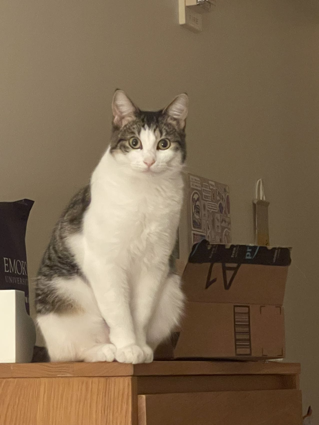

In [3]:
from PIL import Image
image = Image.open('img/sample_img/1181667592680_.pic.jpg')
image = image.resize((image.width//4, image.height//4))
display(image)

Below is a sample run that shows the sample result on the image and how we saved the data in "res".

In [4]:
res = detect_labels('1181667592680_.pic.jpg', False, 'qtm350project', True)
res

Detected cat labels for 1181667592680_.pic.jpg

  Bounding box
    Top: 0.20432382822036743
    Left: 0.09691555052995682
    Width: 0.4994608163833618
    Height: 0.6523746848106384
  Confidence: 95.3527603149414



(True,
 {'Name': 'Cat',
  'Confidence': 95.3527603149414,
  'Instances': [{'BoundingBox': {'Width': 0.4994608163833618,
     'Height': 0.6523746848106384,
     'Left': 0.09691555052995682,
     'Top': 0.20432382822036743},
    'Confidence': 95.3527603149414}],
  'Parents': [{'Name': 'Animal'}, {'Name': 'Mammal'}, {'Name': 'Pet'}]})

We use the invert function to change a positive image to a negative image where the lightest areas of the cat are changed to the darkest and the darkest areas appear as the lightest. And in the same idea as above, we resized the pictures to better fit in the notebook, and stored the inversed pictures in "image_inv". 

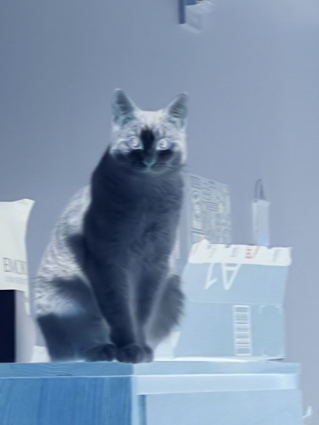

In [27]:
image_inv = PIL.ImageOps.invert(image)
image_inv.save('./img/sample_img/inv_1181667592680_.pic.jpg')
display(image_inv)

After the manipulations on the image, we run the model again to test its functionality.

In [28]:
res = detect_labels('./img/sample_img/inv_1181667592680_.pic.jpg', True, 'qtm350project')
res

(True,
 {'Name': 'Cat',
  'Confidence': 97.43516540527344,
  'Instances': [{'BoundingBox': {'Width': 0.5073033571243286,
     'Height': 0.6589224934577942,
     'Left': 0.09721008688211441,
     'Top': 0.20238830149173737},
    'Confidence': 93.23741149902344}],
  'Parents': [{'Name': 'Animal'}, {'Name': 'Mammal'}, {'Name': 'Pet'}]})

### Sample Result: 

Cats were detected both in the original picture and inversed picture, with similar confidence (around 95 vs. 96). Interestingly, we tested multiple times and got the same result -- the inversed picture has slightly higher confidence than the original picture. This is unexpected -- we expect picture manipulation to lower the confidence. 

Side notes: We ignored the boundingbox here because ML usually lacks interpretablity, and the boundingbox might only be a rough approximation of the data that the ML API actually uses. Anothe reason is that it's not the main focus of our model. 

## Analysis

To get more information on the result we generated from the sample, we run the model on more than 70 pictures of Icy's Jenny's cats. Again, we used the original pictures as baseline, and applied different manipulation, including inverse, rotate, crop&shuffle, and blur, as treatments. We believe we will be able to make generalization and draw a stronger conclusion on larger sample. 

### Get data

To make the baseline, we already stores all our original pictures in the public s3 bucket named "qtm350project". We clarified the bucket name and stored the bucket object in "my_bucket" for future call. 

We called all the image from the bucket, and in order to check our progress, we print the image names. 

In the baseline run, all sample image taken by the group member would run through the AWS ML API. 

In [7]:
s3_resource = boto3.resource('s3')
my_bucket = s3_resource.Bucket('qtm350project')
summaries = my_bucket.objects.all()
image_names = [image.key for image  in summaries]
image_names

['1181667592680_.pic.jpg',
 '1191667592682_.pic.jpg',
 '1201667592682_.pic.jpg',
 '1211667592683_.pic.jpg',
 '1221667592684_.pic.jpg',
 '1231667592685_.pic.jpg',
 '1241667592688_.pic.jpg',
 '1251667592691_.pic.jpg',
 '1261667592692_.pic.jpg',
 '1271667592693_.pic.jpg',
 '1281667592694_.pic.jpg',
 '1291667592695_.pic.jpg',
 '1301667592696_.pic.jpg',
 '1311667592697_.pic.jpg',
 '1321667592698_.pic.jpg',
 '1331667592699_.pic.jpg',
 '1341667592700_.pic.jpg',
 '1351667592702_.pic.jpg',
 '1361667592702_.pic.jpg',
 '1371667592703_.pic.jpg',
 'IMG_0590.jpg',
 'IMG_0606.jpg',
 'IMG_0608.JPG',
 'IMG_0611.jpg',
 'IMG_0622.JPG',
 'IMG_0639.jpg',
 'IMG_0642.jpg',
 'IMG_0695.jpg',
 'IMG_0699.jpg',
 'IMG_0729.jpg',
 'IMG_0859.jpg',
 'IMG_0863.jpg',
 'IMG_0886.jpg',
 'IMG_0931.jpg',
 'IMG_0945.jpg',
 'IMG_0962.JPG',
 'IMG_1250.jpg',
 'IMG_1380.jpg',
 'IMG_1424.jpg',
 'IMG_1425.jpg',
 'IMG_1443.jpg',
 'IMG_1454.jpg',
 'IMG_1506.JPG',
 'IMG_1530.jpg',
 'IMG_1547.jpg',
 'IMG_1639.jpg',
 'IMG_1641.jpg',
 

We fetch all images from S3 bucket. If we fail, it will print "Unable to get". We also want to test how different manipulations can impact the accuracy of the model. Hence, we decide to compare the results from original images, inversed image, rotated images, cropped images, and blurred images. In each methods of manipulating the images, we also want to compare the difference between analyzing high clarity images and low clarity images.

In [8]:
! mkdir temp/original
! mkdir temp/rotate
! mkdir temp/crop
! mkdir temp/blur
! mkdir temp/inverse

In [9]:
for name in image_names:
    try:
        s3_resource.Bucket('qtm350project').download_file(name, f'temp/original/{name}')
    except:
        print(f'Unable to get {name}')

### Data Manipulation

Some data manipulation would be done on the original image to investigate the effect of how different operation would impact AWS ML performance.  
- Inverse
  - Inverse the color the of image
- Rotation
    - rotation of 60, 90, and 180 degrees would be discussed
- Cut and Shuffle
    - cut the image onto four pieces and rearrange it in different order
- Blur
    - blur the image by mean and motion

- #### Inverse
The function below inverse the color of the image and save it to a folder. If we failed, the image will be printed out. And we displayed the resized inversed picture as an example, which is the same picture with our sample analyzed above. 

In [10]:
import os
for item in os.listdir("temp/original/"):
  try:
    raw = PIL.Image.open("temp/original/" + item)
    PIL.ImageOps.invert(raw).save("temp/inverse/" + item)
  except:
    print(item)
    

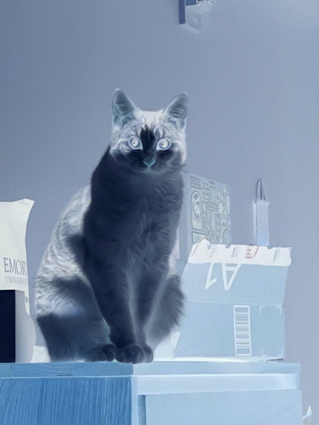

In [11]:
image = Image.open('temp/inverse/1181667592680_.pic.jpg')
image = image.resize((image.width//4, image.height//4))
display(image)

- #### Rotation

The function below allows us to rotate each image by 60 degrees, 90 degrees, and 180 degrees. The manipulated imaged will be saved in the rotate folder under the temp folder. These new images will also be renamed according to their degrees of rotation for clarity. 

If we failed, the image will be printed out. And we displayed three different resized rotated pictures as examples. 

In [12]:
for item in os.listdir("temp/original/"):
    try:
        if "MX" not in item and "MEAN" not in item and "CROP" not in item:
            raw = PIL.Image.open("temp/original/" + item)
            raw.rotate(60).save("temp/rotate/ROTATE60" + item)
            raw.rotate(90).save("temp/rotate/ROTATE90" + item)
            raw.rotate(180).save("temp/rotate/ROTATE180" + item)
    except:
        print(item)

Below is the illustration of the effect of different degrees of rotation.

- 60 degree: 

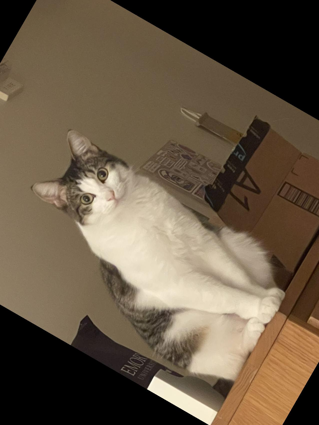

In [13]:
image = Image.open('temp/rotate/ROTATE601181667592680_.pic.jpg')
image = image.resize((image.width//4, image.height//4))
display(image)

- 90 degree: 

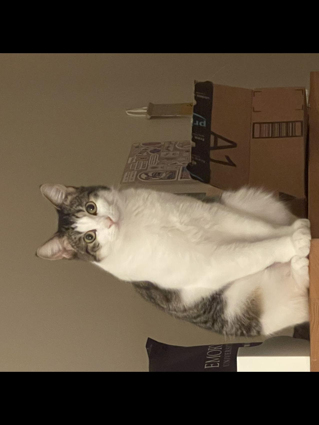

In [14]:
image = Image.open('temp/rotate/ROTATE901181667592680_.pic.jpg')
image = image.resize((image.width//4, image.height//4))
display(image)

- 180 degree: 

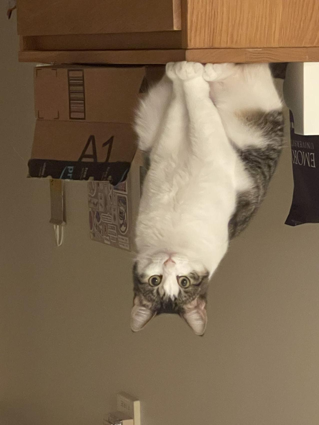

In [15]:
image = Image.open('temp/rotate/ROTATE1801181667592680_.pic.jpg')
image = image.resize((image.width//4, image.height//4))
display(image)

- #### Cut and Shuffle

We evenly cut each image in to 4 pieces, we randomly shuffle the order of all cutted images. Then, new images will be saved in the crop folder of the temp folder. In this way, we differentiate the processed images from the original inputs. 

If we failed, the image will be printed out. And we displayed three different resized cut&shuffled pictures as examples. 

In [16]:
import random

def crop(img, rst):
    raw = np.array(img)
    h = raw.shape[0]
    w = raw.shape[1]
    divide1 = int(h/2)
    divide2 = int(w/2)
    scattered = {}
    scattered["p1"] = raw[0:divide1, 0:divide2]
    scattered["p2"] = raw[divide1:2*divide1, 0:divide2]
    scattered["p3"] = raw[0:divide1, divide2:2*divide2]
    scattered["p4"] = raw[divide1:2*divide1, divide2:2*divide2]
    
    raw_copy = np.copy(raw)
    raw_copy[0:divide1, 0:divide2] = scattered[rst[0]]
    raw_copy[divide1:2*divide1, 0:divide2] = scattered[rst[1]]
    raw_copy[0:divide1, divide2:2*divide2] = scattered[rst[2]]
    raw_copy[divide1:2*divide1, divide2:2*divide2] = scattered[rst[3]] 
    return raw_copy

def get_order():
    flag = True
    order = None
    while flag:
        order = random.sample(["p1","p2","p3","p4"],4)
        if ["p1","p2","p3","p4"] != order:
            flag = False
    return order

fs = os.listdir("temp/original/")
for item in fs:
    try:
        PIL.Image.fromarray(crop(Image.open("temp/original/" + item), get_order())).save("temp/crop/" + item)
    except:
        print("Problem:" + item)

Below is an illustration of the effect of cut and shuffle.

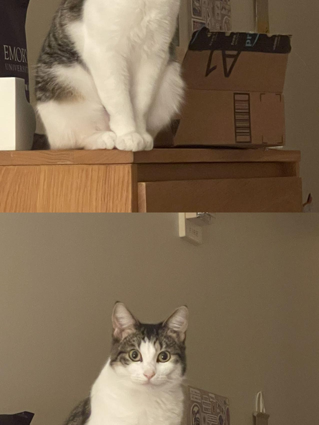

In [17]:
image = Image.open('temp/crop/1181667592680_.pic.jpg')
image = image.resize((image.width//4, image.height//4))
display(image)

##### Check point

We used the test below to make sure two cats (cropped&shuffled) will not return multiple cats. 

In [3]:
import cv2
img1 = cv2.imread('temp/original/1181667592680_.pic.jpg')
img2 = cv2.imread('temp/original/1181667592680_.pic.jpg')
img = cv2.vconcat([img1, img2])
cv2.imwrite("123.jpg",img)

True

In [1]:
import boto3
client=boto3.client('rekognition')
with open("123.jpg", 'rb') as image_file:
    image = image_file.read()
    response = client.detect_labels(Image={'Bytes': image})
    
count = 0
for label in response['Labels']:
    if label['Name'] == 'Cat':
        count = count + 1

count

1

- #### Blur

With the code below, we blurred the images in two ways. One is by mean while the other is by motion. New images will be saved in the blur folder under the temp folder. The images will be renamed by their methods of blurring. 

If we failed, the image will be printed out with "Problem" label. And we displayed two different resized blurred pictures with different blurring methods as examples. 

In [18]:
import cv2
import numpy as np
import os

def meanBlur(image,save_path):
    dst2 = cv2.medianBlur(image, 15)
    cv2.imwrite(save_path, dst2)
    return

# This function is referenced from the blog: https://blog.csdn.net/Wadewhl/article/details/112998830
def motionBlur(image, save_path, degree= 15, angle=45):
    image = np.array(image)
    # higher the degree, more blurred the image
    M = cv2.getRotationMatrix2D((degree / 2, degree / 2), angle, 1)
    motion_blur_kernel = np.diag(np.ones(degree))
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (degree, degree))
    motion_blur_kernel = motion_blur_kernel / degree
    blurred = cv2.filter2D(np.float32(image), -1, motion_blur_kernel)
    cv2.normalize(blurred, blurred, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(save_path, blurred)
    return

fs = os.listdir("temp/original/")
for item in fs:
    try:
        image = cv2.imread(f'temp/original/{item}')
        meanBlur(image, f'temp/blur/mean_{item}')
        motionBlur(image, f'temp/blur/motion_{item}')
    except:
        print("Problem:" + item)

Below is an illustration of the effect of blurred.

- mean: 

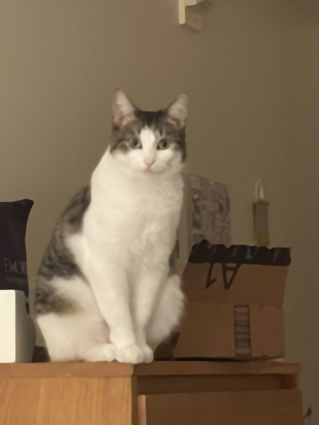

In [19]:
image = Image.open('temp/blur/mean_1181667592680_.pic.jpg')
image = image.resize((image.width//4, image.height//4))
display(image)

- motion: 

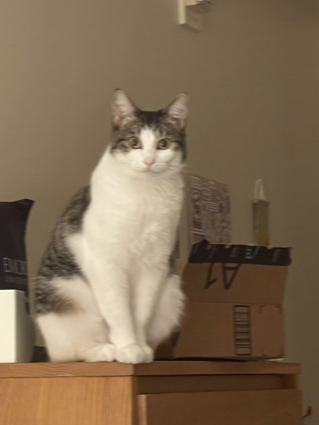

In [20]:
image = Image.open('temp/blur/motion_1181667592680_.pic.jpg')
image = image.resize((image.width//4, image.height//4))
display(image)

### Run ML API
Below is a helper funtion to run ML API on all files in a given directory. We can utilize this function to run ML API on a selected folder, and store results to a variable "rsts". 

In [3]:
import os
import pandas as pd

def predict(dir_path):
    ls = os.listdir(dir_path)
    file_list = []
    conf_list = []
    for l in ls:
        try:
            _, res = detect_labels(dir_path + l, True)
            file_list.append(l)
            conf_list.append(res['Confidence'])
        except:
            print(f'Error in running ML API on {l}')
    return file_list, conf_list

- #### Baseline Run
In the baseline run, all sample image taken by the group member would run through our ML model. In this attempt, all the images we are analyzing are the original, unaltered images we initially uploaded.

In [4]:
file_orig, conf_orig = predict("temp/original/")
df_res_orig = pd.DataFrame(list(zip(file_orig, conf_orig)), columns =['Filename', 'Confidence'])
df_res_orig.head()

Error in running ML API on .ipynb_checkpoints
Error in running ML API on 1201667592682_.pic.jpg


,Filename,Confidence
0,IMG_0590.jpg,96.893723
1,IMG_0611.jpg,79.788628
2,1231667592685_.pic.jpg,95.247971
3,1301667592696_.pic.jpg,93.797470
4,IMG_2398.jpg,87.700523


- #### Inverse Run
In the inverse run, all invered image would run through our ML model. 

In [5]:
file_inv, conf_inv = predict("temp/inverse/")
df_res_inv = pd.DataFrame(list(zip(file_inv, conf_inv)), columns =['Filename', 'Confidence'])
df_res_inv.head()

Error in running ML API on IMG_0606.jpg
Error in running ML API on IMG_2189.jpg


,Filename,Confidence
0,IMG_0590.jpg,92.158424
1,IMG_0611.jpg,74.464577
2,1231667592685_.pic.jpg,90.549469
3,1301667592696_.pic.jpg,89.133110
4,IMG_2398.jpg,83.212868


- #### Rotation Run

In the rotation run, all the rotated image would run through our ML model. In this attempt, all the images we are analyzing are either rotated by 60, 90, or 180 degrees.

In [6]:
file_rot, conf_rot = predict("temp/rotate/")
df_res_rot = pd.DataFrame(list(zip(file_rot, conf_rot)), columns =['Filename', 'Confidence'])
df_res_rot.head()

Error in running ML API on ROTATE180IMG_0611.jpg
Error in running ML API on ROTATE90IMG_0590.jpg
Error in running ML API on ROTATE90IMG_0611.jpg
Error in running ML API on ROTATE60IMG_0611.jpg


,Filename,Confidence
0,ROTATE60IMG_0863.jpg,93.860413
1,ROTATE180IMG_4440.jpg,97.712723
2,ROTATE901371667592703_.pic.jpg,97.161140
3,ROTATE1801331667592699_.pic.jpg,86.154625
4,ROTATE901341667592700_.pic.jpg,97.513336


- #### Cut and Shuffle Run

In the cut and shuffle run, all the cropped image would run through our ML model. In this attempt, all the images we are analyzing are cropped from the original input images, and their order has been randomly shuffled to avoid bias.

In [7]:
file_crop, conf_crop = predict("temp/crop/")
df_res_crop = pd.DataFrame(list(zip(file_crop, conf_crop)), columns =['Filename', 'Confidence'])
df_res_crop.head()

Error in running ML API on IMG_0611.jpg
Error in running ML API on IMG_1643.jpg


,Filename,Confidence
0,IMG_0590.jpg,97.098434
1,IMG_0611.jpg,91.126236
2,1231667592685_.pic.jpg,93.914513
3,1301667592696_.pic.jpg,83.463669
4,IMG_2398.jpg,89.845284


- #### Blur Run

In the blur run, all the blurred image would run through our ML model. In this attempt, all the images we are analyzing are blurred either by mean or motion.

In [8]:
file_blur, conf_blur = predict("temp/blur/")
df_res_blur = pd.DataFrame(list(zip(file_blur, conf_blur)), columns =['Filename', 'Confidence'])
df_res_blur.head()

Error in running ML API on mean_1201667592682_.pic.jpg
Error in running ML API on motion_1201667592682_.pic.jpg


,Filename,Confidence
0,mean_IMG_0590.jpg,96.052925
1,motion_IMG_4427.jpg,99.653770
2,motion_1311667592697_.pic.jpg,88.007210
3,mean_IMG_0863.jpg,98.546112
4,mean_IMG_2380.jpg,97.095428


### Analysis on the baseline: 

We calculated the mean confidence:   

In [9]:
mean_orig = df_res_orig['Confidence'].mean()

print(mean_orig)

93.95637878417969


### Analysis on the effect of inverse

We calculated the mean confidence:   

In [10]:
mean_inv = df_res_inv['Confidence'].mean()

print(mean_inv)

89.85106581610603


### Analysis on the effect of rotation

We calculated the mean confidence:   

In [11]:
mean_rot = df_res_rot['Confidence'].mean()

print(mean_rot)

93.08771189621517


### Analysis on the effect of crop&shuffle

We calculated the mean confidence:   

In [12]:
mean_crop = df_res_crop['Confidence'].mean()

print(mean_crop)

90.47519158028267


### Analysis on the effect of blur

We calculated the mean confidence:   

In [13]:
mean_blur = df_res_blur['Confidence'].mean()

print(mean_blur)

93.92385838826497


### Visualization

We built up five boxplots to visualize the distribution of the confidence output for each group (baseline, inverse, rotate, crop&shuffle, blur). 

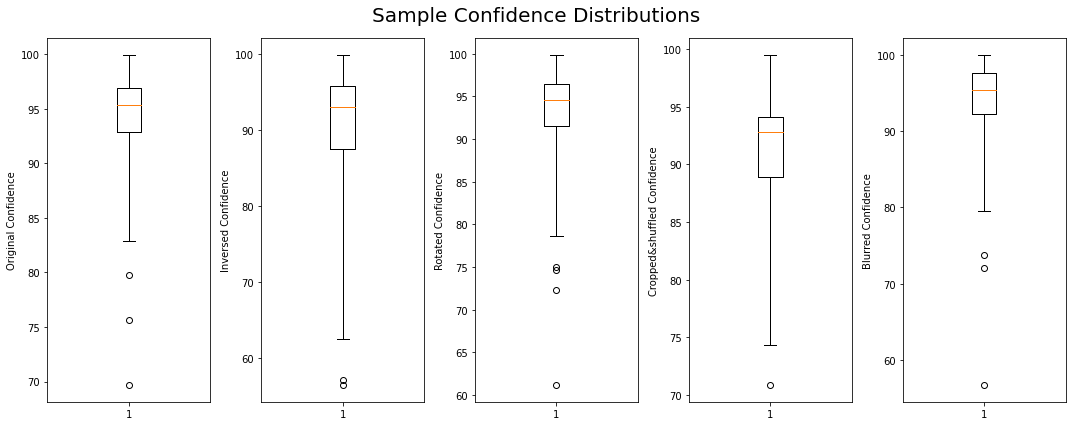

In [36]:
# import our main library for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (15,6))

# plot each variable on a boxplot
ax1.boxplot(df_res_orig['Confidence'], whis = 3)
ax2.boxplot(df_res_inv['Confidence'], whis = 3)
ax3.boxplot(df_res_rot['Confidence'], whis = 3)
ax4.boxplot(df_res_crop['Confidence'], whis = 3)
ax5.boxplot(df_res_blur['Confidence'], whis = 3)

# label each axes
ax1.set_ylabel('Original Confidence')
ax2.set_ylabel('Inversed Confidence')
ax3.set_ylabel('Rotated Confidence')
ax4.set_ylabel('Cropped&shuffled Confidence')
ax5.set_ylabel('Blurred Confidence')

# add a title
plt.suptitle('Sample Confidence Distributions', fontsize = 20)

# to make y labels fit a bit better
plt.tight_layout()

- The mean confidence of baseline is about 94
- The mean confidence of inversed pictures is about 90
- The mean confidence of rotated pictures (for 60 degree, for 90 degree, for 180 degree) is about 93
- The mean confidence of cropped&shuffled pictures is about 90.5
- The mean confidence of blurred pictures (for mean, for motion) is about 94

As expected, our baseline has the largest mean confidence, indicating that the ML is able to identify cat accuratly in a normal baseline picture with very high confidence. In terms of distribution, the baseline group has more concentrated distribution with less outliers. However, the minimum value is still above 69. 

The blurred group has the second largest mean confidence (-0.02 confidence on average). Although it returned with less confidence compared to the baseline, they gave me quite similar result. Therefore, in the real world, it might not matter that much for the cat to move fast so that we get blurred pictures. In terms of distribution, the blurred group is more spreaded out with less outliers. In addition, the minimum value is below 60. 

Then, the rotated group follows. It has lower mean confidence than the pevious two groups. However, without doubt, AWS rekognition is able to identify the cat. Therefore, rotation of the image (different angles and gestures of cats in real world) will lower the accuracy of AWS rekognition a little bit, but no too much. In terms of distribution, the rotated group has more concentrated distribution but with more outliers. And, the minimum value is about 60.  

The cropped&shuffled group has the second least mean confidence. Although ML recognized the cat, it returned with less confidence compared to the baseline. However, it is higher than the confidence of inversed group. We believe this is because sometimes we cropped but left the whole cat head there so it can be accurately identified. But, in the real world, hiding cats will lower the confidence of recognition. In terms of distribution, the cropped&shuffled group has more spreaded out distribution with only one outlier. However, the minimum value is still above 70. 

The inversed group has the least mean confidence. We still believe this value is high enough for us to state that AWS rekognition recognized the cat, it returned with less confidence compared to the baseline. Therefore, inversed pictures (color change) will lower the accuracy of AWS rekognition in the real world. In terms of distribution, the inversed group has more concentrated distribution but with three outliers. And, the minimum value is below 60. 

### Statistical Analysis

To test the difference between the AWS Rekognition confidence across the treatment groups, we performed multiple t-test comparing each individual treatment groups with the baseline control group. From the tables generated below, we can see the independent t-test summary statistics. 

The null hypothesis is “The image modulation treatment does not lead to significantly different perforce in AWS Rekognition’s cat detection confidence, orginal_confidence - treated_confidence = 0.” Meanwhile, the alternative hypothesis argues for significant difference in the treatment groups. In short, we are looking at when the difference is <0 or >0. Corresponding to this table, we should look at the two side test p-value.

To do this, we installed the package called reseachpy and imported it as rp. 

In [15]:
!pip install researchpy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


A t-test between original control group and “Coloration Inversion” group, give a mean difference of 4.1053 with a p-value of 0.0015, which is much smaller than the critical value of 0.05, suggesting that the difference is significant. Hence, given the mean difference is positive, we can reject the null hypothesis and accept the alternative one that Color Inversion leads to worse confidence of cat recognition in AWS Rekognition. 

In [24]:
import researchpy as rp

summary, res = rp.ttest(group1 = df_res_orig["Confidence"], group1_name = "Original", group2 = df_res_inv["Confidence"], group2_name = "Inverse")

res

,Independent t-test,results
0,Difference (Original - Inverse) =,4.1053
1,Degrees of freedom =,147.0000
2,t =,3.2342
3,Two side test p value =,0.0015
4,Difference < 0 p value =,0.9992
5,Difference > 0 p value =,0.0008
6,Cohen's d =,0.5299
7,Hedge's g =,0.5272
8,Glass's delta1 =,0.7667
9,Point-Biserial r =,0.2577


A t-test between original control group and “Rotation” group, give a mean of 0.8687 with a p-value of 0.2232, which is greater than the critical value of 0.05, suggesting that the difference is insignificant. Hence, we cannot reject the null hypothesis, proving that rotation does not affect the confidence of identifying cats in AWS Rekognition.

In [25]:
summary, res = rp.ttest(group1 = df_res_orig["Confidence"], group1_name = "Original", group2 = df_res_rot["Confidence"], group2_name = "Rotation")

res

,Independent t-test,results
0,Difference (Original - Rotation) =,0.8687
1,Degrees of freedom =,297.0000
2,t =,1.2206
3,Two side test p value =,0.2232
4,Difference < 0 p value =,0.8884
5,Difference > 0 p value =,0.1116
6,Cohen's d =,0.1628
7,Hedge's g =,0.1624
8,Glass's delta1 =,0.1622
9,Point-Biserial r =,0.0706


A t-test between original control group and “Crop and Shuffle” group, give a mean difference of 3.4812 with a p-value of 0.0005, which is much smaller than the critical value of 0.05, suggesting that the difference is significant. Hence, given the mean difference is positive, we can reject the null hypothesis and accept the alternative one that cropping and shuffling the images leads to worse confidence of cat recognition in AWS Rekognition.

In [26]:
summary, res = rp.ttest(group1 = df_res_orig["Confidence"], group1_name = "Original", group2 = df_res_crop["Confidence"], group2_name = "Crop")

res

,Independent t-test,results
0,Difference (Original - Crop) =,3.4812
1,Degrees of freedom =,147.0000
2,t =,3.5441
3,Two side test p value =,0.0005
4,Difference < 0 p value =,0.9997
5,Difference > 0 p value =,0.0003
6,Cohen's d =,0.5807
7,Hedge's g =,0.5777
8,Glass's delta1 =,0.6501
9,Point-Biserial r =,0.2806


A t-test between original control group and “Blurring” group, give a mean difference of 0.0325 with a p-value of 0.9680,  which is greater than the critical value of 0.05, suggesting that the difference is insignificant. Hence, we cannot reject the null hypothesis. This contradicts with our initial expectation that blurring will lead to the most lowering of machine learning capability. It appears that AWS Rekognition does not heavily rely on a clear contour of object in the learning process.

In [27]:
summary, res = rp.ttest(group1 = df_res_orig["Confidence"], group1_name = "Original", group2 = df_res_blur["Confidence"], group2_name = "Blur")

res

,Independent t-test,results
0,Difference (Original - Blur) =,0.0325
1,Degrees of freedom =,223.0000
2,t =,0.0402
3,Two side test p value =,0.9680
4,Difference < 0 p value =,0.5160
5,Difference > 0 p value =,0.4840
6,Cohen's d =,0.0057
7,Hedge's g =,0.0057
8,Glass's delta1 =,0.0061
9,Point-Biserial r =,0.0027


## Conclusion

As we expected in the hypotheses section, the baseline has the largest mean confidence, followed by the blurred group, rotated group, cropped&shuffled group, and inversed group. 

It is partially consistent with our expectations that the manipulation with less shape distortion will give us high confidence after running the model. However, for the rotate group, the result is not statistically significant, indicating that picture angles and flat cat gestures will affect the ML accuracy. This might because that AWS ML do recognition on all angles already. 

We did not expect blurred pictures to have that much confidence because there is little shape distortion involved. However, it is with relatively low significance. Therefore, the object rekognition will be influenced when the cat is running fast. We think this is because shape recognition is still an important conponent of object rekognition. 

The cropped&shuffled group has relatively lower mean confidence with high significance, which should be caused by separating cat head and lower the accuracy of recognition. However, the result is still higher than the inversed group. We believe this is because sometimes we cropped but left the whole cat head there so it can be accurately identified. But, in the real world, hiding cats will lower the confidence of recognition. 

We conclude that color should be another important component of object recognition of since the inversed group has the least mean confidence with high significance. It lowers the recognition accuracy when the color of the pictures is inversed from its natural color. 

## Space for Improvement

In our study, we picked variables to simulate mainly different shape distortion but only one color change. However, we can concluded that color is also an important component of object recognition. Future studies should design more variables to simulate different types of color change to have a more comprehensive understanding on the effects of color on AWS rekognition. 

## Works Cited

https://www.suneratech.com/blog/ai-ml-and-how-they-are-applied-to-facial-recognition-technology/
https://www.britannica.com/technology/negative
https://docs.aws.amazon.com/rekognition/latest/dg/images.html